# Boston Airbnb Business Analysis

Airbnb started off on a simple idea: affordable accommodations for travellers and some side income for homestay providers. After 14 years, this idea has evolved into a mature online business with hundreds of thousands of online bookings every day. The large amount of booking and review data collected behind scene will reveal some patterns or business insights in this billion-dollar marketplace.

## 1. Business understanding


This notebook uses Boston Airbnb open data from Kaggle to draw an Airbnb homestays activity analysis.
Business questions to be answered. 
1.	How are listings distributed in Boston?
2.	How do listing price and booking rate change throughout the year?
3.	What do people value the most about their homestays?
4.	Can listing price be predicted?

## 2. Data understanding

There are three files provided by Kaggle. 
Calendar file shows the price and availability of 3,585 property listings during Sep 2016-Sep 2017. With this data, we can gain some insights in how price and booking rate change throughout the year. 
Notes about this dataset:
1. Availability of 365 days of 3,585 listings
2. Price is only shown when a listing is available, is null when a listing is unavailable

The second file is reviews, which includes reviews for 2,829 listings from 2009 to 2016. Reviews will tell us what people value the most about their Airbnb stays. 
The last file is listings. This file contains detailed information about each listing, such as property features, host information, listing descriptions and review scores. We will be using this data to answer the rest of questions. A few notes about listing dataset. 
1.	It’s a snapshot of 3,585 Airbnb listings on Sept 6th,2016
2.	Dataset includes numerical, categorical variables and text variables that need further natural language processing.
3.	Missing values in both numerical and categorical variables.
4.	Listings price variable is shown as object, not numerical, as it contains dollar sign and comma  


## 3. Data cleaning and exploratory analysis

A few libraries for data cleaning and exploration process

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### 3.1 Import files

In [70]:
listing_b=pd.read_csv('listings_boston.csv')
review_b=pd.read_csv('reviews_boston.csv')
calendar_b=pd.read_csv('calendar_boston.csv')

### 3.2 How do listing price and booking rate change throughout the year?

Text(0.5, 1.0, 'Avg % of booked properties change during Sept 2016 - Sept 2017')

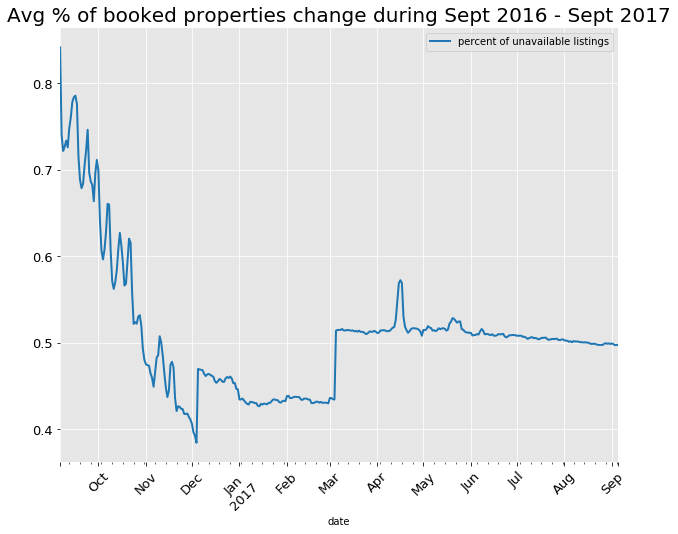

In [4]:
# listing_id 12898806 is shown twice in calendar file
calendar_b=calendar_b.drop_duplicates(keep='first') 

# remove dollar sign in Calendar
calendar_b["price"] = calendar_b["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore').astype(float)

# convert date variable to data dtype
calendar_b.date=pd.to_datetime(calendar_b.date)

# get number of unavailable listings per day
unavailable_listings=calendar_b.loc[calendar_b.available=='f'].groupby(['date']).count()['listing_id']

# get number of total listings per day
total_listings=calendar_b.groupby(['date']).count()['listing_id']

# calculate average percent of booked properities througout the year
booking=pd.concat([unavailable_listings,total_listings],axis=1)
booking.columns=['unavailable_count','total_count']
booking.fillna(0,inplace=True)
booking=booking.reset_index()
booking['percent of unavailable listings']=booking['unavailable_count']/booking['total_count']

# plot booking rate over the year
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
booking.sort_values(by='date').plot(x='date',y='percent of unavailable listings',figsize=(10,8),
                                                                        rot=45,fontsize=13,linewidth=2)
plt.title('Avg % of booked properties change during Sept 2016 - Sept 2017',size=20)

Text(0.5, 1.0, 'Average listing price change during Sept 2016 - Sept 2017')

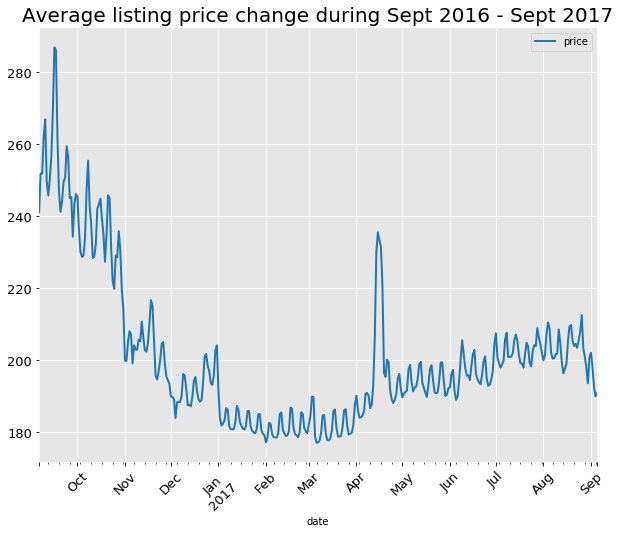

In [5]:
# from Data understanding, we know price isn't shown for unavailable listings in calendar file, so drop rows with no price first
calendar_ava=calendar_b.dropna(subset = ["price"])

# plot average listing price change throughout the year
calendar_ava.groupby('date').mean().reset_index().plot(kind='line',x='date',y='price',linewidth=2,rot=45,fontsize=13,figsize=(10,8))
plt.title('Average listing price change during Sept 2016 - Sept 2017',size=20)

Text(0.5, 1.0, 'Average listing price change each day of the week')

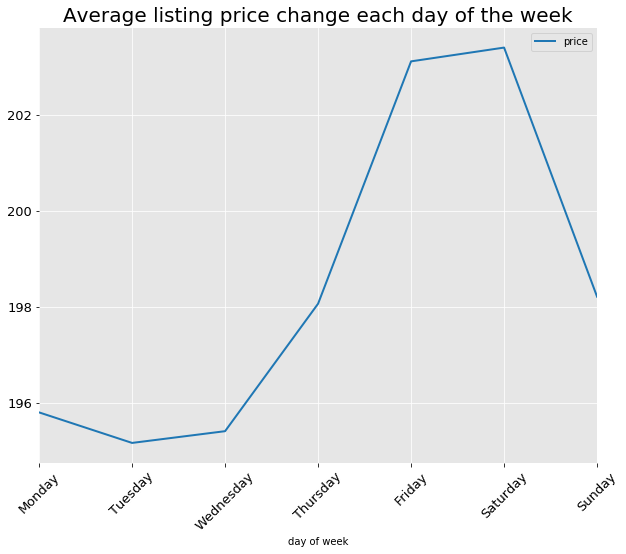

In [6]:
# get weekday name s
calendar_ava['day of week']=calendar_ava.date.dt.day_name()

# categorical weekday names so they will be on x-axis in a chronological order
day_name=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
calendar_ava['day of week'] = pd.Categorical(calendar_ava['day of week'], ordered=True,categories=day_name)

# plot price change per day of the week
calendar_ava.groupby('day of week').mean().reset_index().plot(kind='line',x='day of week',y='price',linewidth=2,rot=45,fontsize=13,figsize=(10,8))
plt.title('Average listing price change each day of the week',size=20)

Generally speaking, booking rate and price increase from winter 2017 to summer 2017. Price trendline shows small cycles within each month due to price swing from weekdays to weekends, while booking rate does not correspondingly reflect high rate on weekends and low rate on weekdays in 2017. Booking rate and price surge in April 2017 due to Boston Marathon. Substantially high booking rate and price also appear in September and October 2016. 




But how do price and booking rate change in different neighborhood? Let's break them down by neighborhoods

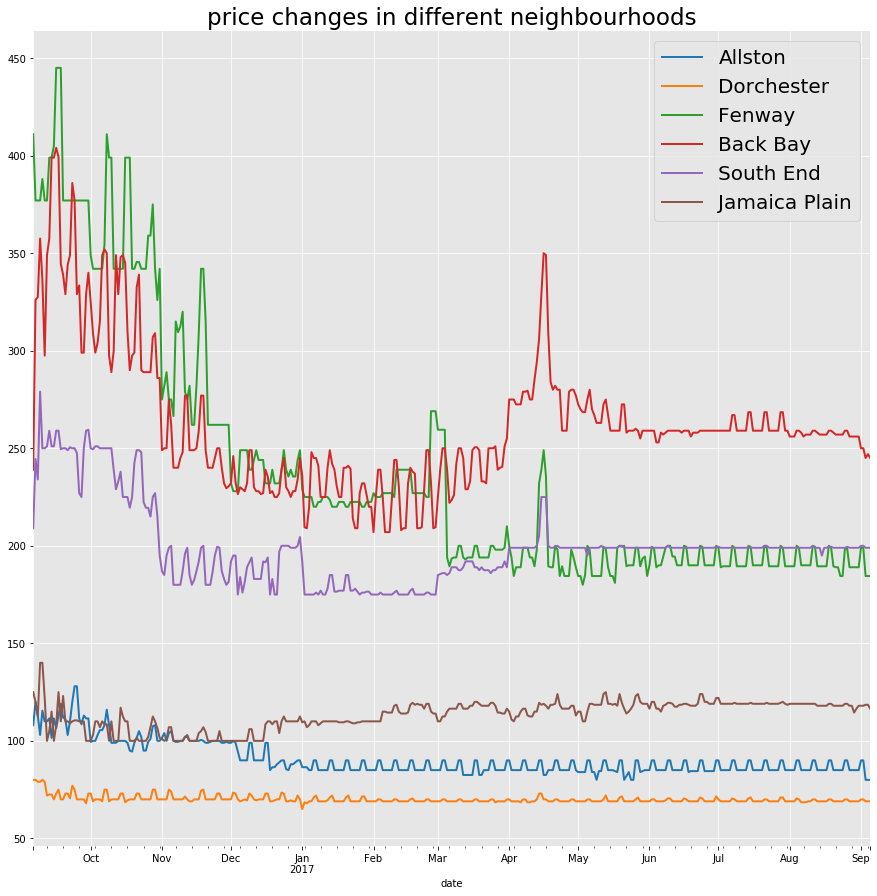

In [7]:
# merge calendar and listing datasets to get neighborhoods
calendar_with_neighborhoods=listing_b[['id','neighbourhood_cleansed']].merge(calendar_b,how='right',left_on='id',right_on='listing_id')

# drop rows with no price and group by date and neighborhood to get median price
neighborhood_price=calendar_with_neighborhoods.loc[calendar_with_neighborhoods.available=='t'].groupby(['date','neighbourhood_cleansed']).median()['price']
neighborhood_price=neighborhood_price.reset_index()

# pivot dataframe so we can plot all price for all six neighborhoods in one figure
neighborhood_price=neighborhood_price.pivot(columns='neighbourhood_cleansed',index='date',values='price')

# plot price change for the top 6 neighbourhoods with the most listings
neighborhood_price[['Allston','Dorchester','Fenway','Back Bay','South End','Jamaica Plain']].plot(figsize=(15,15),legend=True,linewidth=2)
plt.title('price changes in different neighbourhoods',size=23)
plt.legend(fontsize=20)

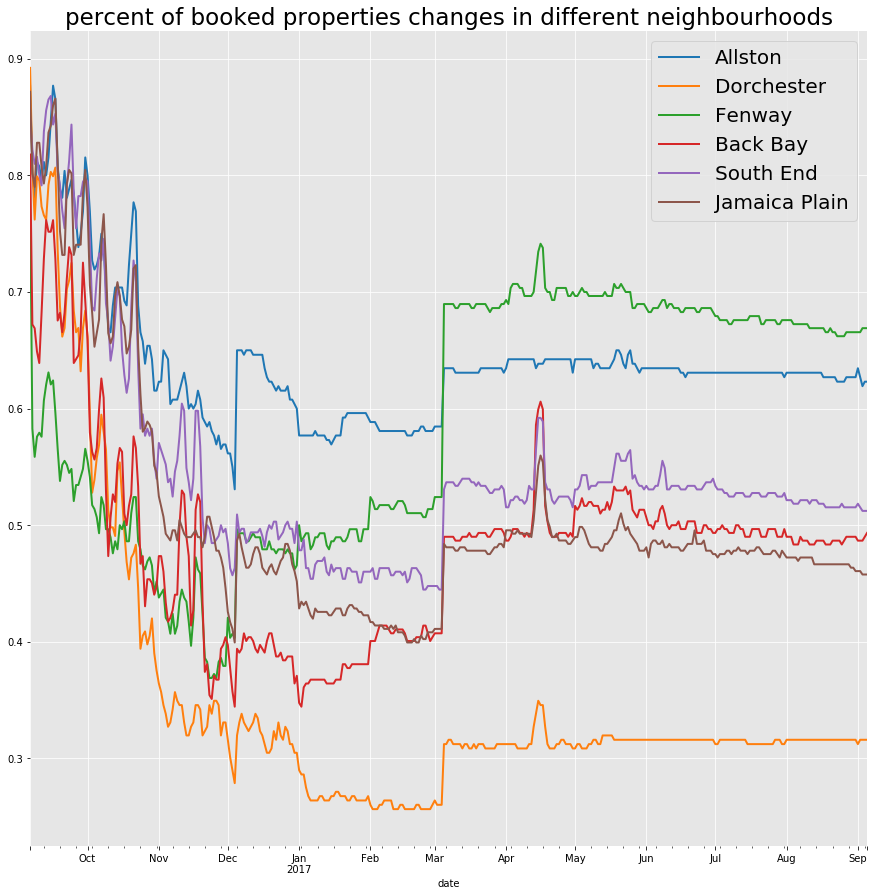

In [8]:
# get available listing count for each neighborhood
neighborhood_ava=calendar_with_neighborhoods.loc[calendar_with_neighborhoods.available=='f'].groupby(['date','neighbourhood_cleansed']).count()['listing_id']
# get total listing count for each neighborhood
neighborhood_total=calendar_with_neighborhoods.groupby(['date','neighbourhood_cleansed']).count()['listing_id']

# booking rate for each neighborhoods 
neighborhood_booking=pd.concat([neighborhood_ava,neighborhood_total],axis=1)
neighborhood_booking.columns=['ava_count','total_count']
neighborhood_booking=neighborhood_booking.reset_index()
neighborhood_booking['percent of unavailable listings']=neighborhood_booking['ava_count']/neighborhood_booking['total_count']

#pivot dataframe to plot different neighborhoods on the same figure
neighborhood_booking=neighborhood_booking.pivot(columns='neighbourhood_cleansed',index='date',values='percent of unavailable listings')

#plot booking rate for the top 6 neighbourhoods with the most listings
neighborhood_booking[[ 'Allston','Dorchester','Fenway','Back Bay','South End','Jamaica Plain']].plot(figsize=(15,15),legend=True,linewidth=2)
plt.title('percent of booked properties changes in different neighbourhoods',size=23)
plt.legend(fontsize=20)

To avoid overlapping on graphs, only the top 6 neighborhood with the most listing number are selected for the analysis. These plots show booking rates rise greatly during September and October 2016 than they are in summer in all neighbourhoods, with the exception of Fenway. Its significantly high price, almost twice as high as its price in summer, makes it less of an attraction to travelers. On the contrast, Dorchester, Allston and Jamaica Plain neighbourhoods remain the same price rates as they are in summer, yet achieve the highest booking rates in September and October 2016. However, booking rates change across different neighbourhoods in summer. Neighbourhoods charge higher prices but with better locations show higher booking rates. 

### 3.3 How are listings distributed in Boston?

In [71]:
# remove rows with missing price
listing_b=listing_b.dropna(subset=['price'])

# Remove dollar sign and comman
listing_b=listing_b.apply(lambda x: x.str.replace('$',"").str.replace(',','').astype('float') if x.dtypes=='O' and \
                          x.str.contains('$',regex=False).sum()== x.notnull().sum()  else x)

listing_b.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


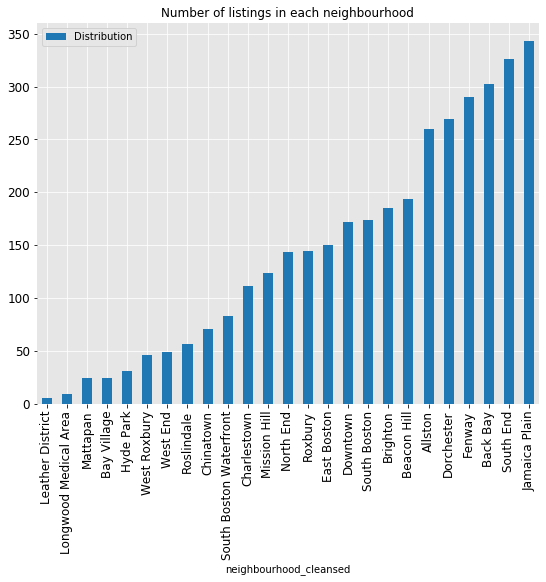

In [10]:
# plot listing distribution
listing_distr=listing_b.groupby('neighbourhood_cleansed').count().reset_index()[['neighbourhood_cleansed','price']].sort_values(by=['price'])
listing_distr.columns=['neighbourhood_cleansed','Distribution']

listing_distr.plot(x='neighbourhood_cleansed',y='Distribution',kind='bar' ,legend=True,figsize=(9,7),fontsize=12,title=
          'Number of listings in each neighbourhood')

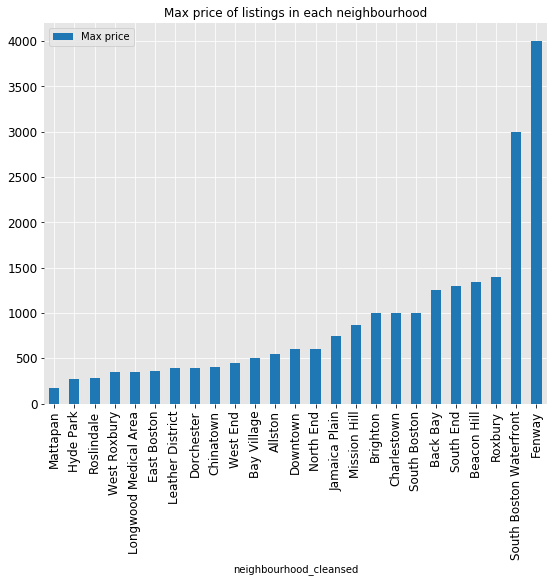

In [11]:
# plot max price across different neighbourhood
listing_max_price=listing_b.groupby(['neighbourhood_cleansed']).max()['price']

listing_max_price=listing_max_price.reset_index()
listing_max_price.columns=['neighbourhood_cleansed','Max price']
listing_max_price.sort_values(by=['Max price']).plot(kind='bar',x='neighbourhood_cleansed',y='Max price',legend=True,
                                                figsize=(9,7),fontsize=12,title='Max price of listings in each neighbourhood')

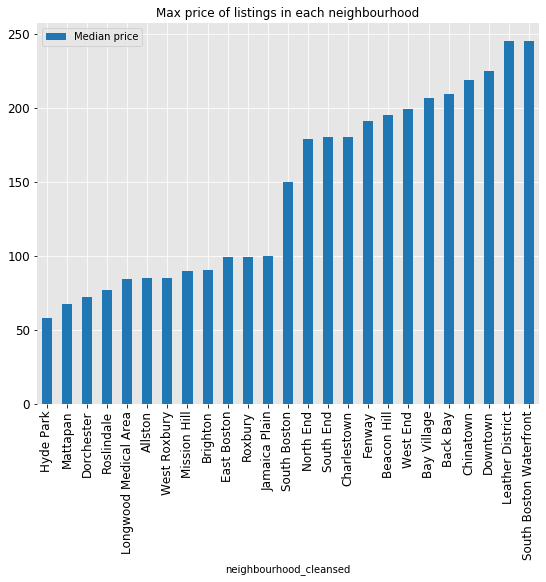

In [12]:
# plot median price across different neighbourhood
listing_avg_price=listing_b.groupby(['neighbourhood_cleansed']).median()['price']
listing_avg_price=listing_avg_price.reset_index()
listing_avg_price.columns=['neighbourhood_cleansed','Median price']

listing_avg_price.sort_values(by=['Median price']).plot(kind='bar',x='neighbourhood_cleansed',y='Median price',legend=True,
                                                figsize=(9,7),fontsize=12,title='Max price of listings in each neighbourhood')

From the bar charts, we can see Jamaica Plain has the most listings in Boston, followed by South End, Back bay and Fenway areas. Leather District has the least listings, but with the highest median listing price in all neighbourhoods. This area is between Financial District and Chinatown. Although it’s small, it holds many offices and luxury lofts in a compact area. Another neighbourhood that draws the highest median listing price, is South Boston Waterfront. Waterfront area has less than 100 listings. But due to its nice location, Airbnb properties are listed at a very high price. Areas, such as Downtown, Chinatown, back bay also show high median prices as they are close to financial district and waterfront. Interestingly, Fenway area holds the most expensive airbnb listing, 4000, followed by a 3000 listing in Waterfront area. A Boston neighbourhood map below visually portrays the distribution of Airbnb listings and meidan price assoicated with it.

### 3.4 What do people value the most about their homestays?

Import a few libraries for language processing

In [13]:
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [81]:
# drop rows with no comment
review_b.dropna(subset=['comments'],inplace=True)

# change all comments to lower case
review_b.comments=review_b.comments.str.lower()

# get listing id and comments pair
review_dic=dict(zip(review_b.listing_id,review_b.comments))

review_dic={}
ids=review_b.listing_id.unique()
for i in ids:
    comment=review_b.loc[review_b.listing_id==i,'comments'].to_list()
    comment=' '.join(comment)
    comment=comment.translate(str.maketrans('', '', string.punctuation))
    comment=comment.split()
    review_dic[i]=comment

print(pd.DataFrame(review_dic.items(), columns=['listing_id','words']).head())

   listing_id                                              words
0     1178162  [my, stay, at, islams, place, was, really, coo...
1     7246272  [my, wife, and, i, had, a, great, experience, ...
2    13658522  [giulios, roommate, nikolai, was, friendly, an...
3     9364092  [the, host, canceled, this, reservation, 13, d...
4    12069214  [location, is, phenomenal, host, was, super, f...


In [ ]:
# combine NPL stop words and a selected stop words from review dataset
stop_words=stopwords.words('english')
review_stopwords = [ 'could','would','boston','us','away','also','great','nice','apartment','room','house','home','place','alex','bob','like',
          'good','days','recommend','everything','get','even','made','staying','back','needed','de','little','one','two','definitely',
          'well','wonderful','always','fine','excellent','day','really','perfect','3','4','5','stay','around']

# get review word counts dictionary and sort dictionary in a descending order
stop_words.extend(review_stopwords)
top_word_count={}
for i in review_dic.keys():

    temp_id=dict(Counter([word for word in review_dic[i] if word not in stop_words]))
    for idx, (k,v) in enumerate(temp_id.items()):
        if k=='walking':
            k='walk'
        if k in top_word_count.keys():
            top_word_count[k]=top_word_count[k]+v
        else:           
            top_word_count[k]=v
top_word_count=dict(sorted(top_word_count.items(),key=lambda item:item[1],reverse=True))      

print(pd.DataFrame(top_word_count.items(), columns=['word','count']).head())

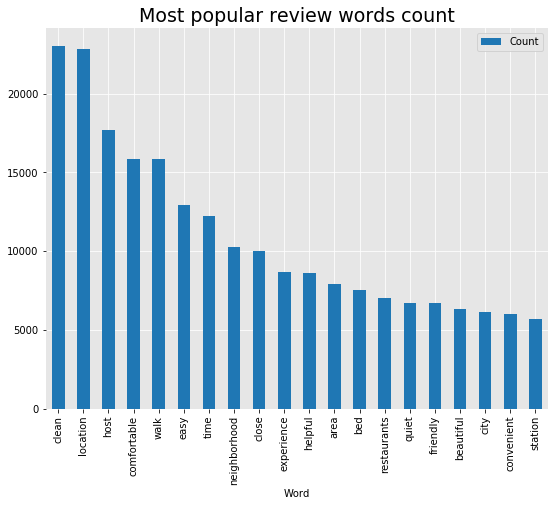

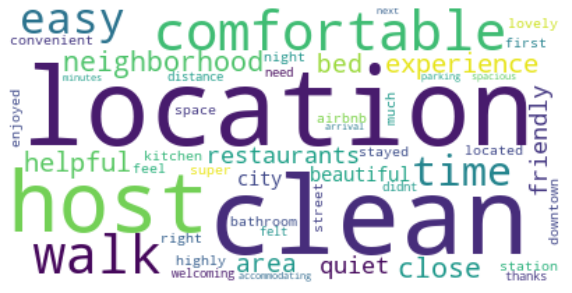

In [16]:
# convert dictionary to a dataframe first
df_top=pd.DataFrame(top_word_count.items(),columns=['Word','Count'])
# plot word count bar chart
df_top.iloc[:20,:].plot(kind='bar',x='Word',y='Count',figsize=(9,7))
plt.title('Most popular review words count',size=19)
words=''

# convert word count dataframe to word cloud string
for i in range(50):
    words+=(df_top.iloc[i,0]+' ')*df_top.iloc[i,1]
wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3,contour_color='firebrick',collocations = False)

#plot word cloud
wordcloud.generate(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The bar chart presents the top 20 most popular word counts in reviews. The Word cloud shows the top 50 popular words. From the ranking, we can see cleanness and location are mentioned the most in reviews. A few popular words that are also relative to location are “close”, “walk”, “convenient”,” station”. Convenient location appears to be most the important factor for an Airbnb homestay. Communication and interaction with host is the third most frequently mentioned point in reviews. Quiet neighbourhood and bed quality are also important features to people.

## 4. Price prediction model

Now it's time to predict listing price with our listing dataset. Let's do some descrepitive analyses to prepare the dataset for models first 

total number of listings:  3585


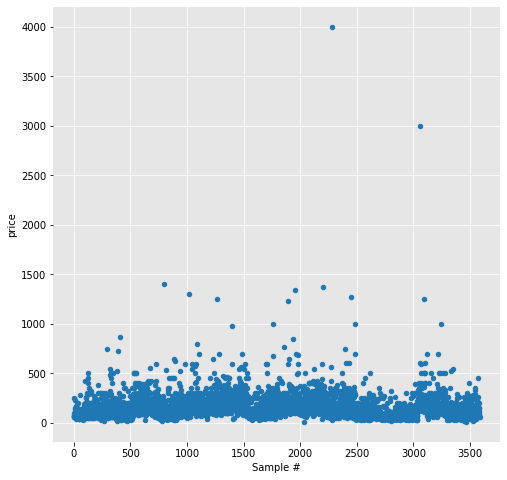

In [72]:
# plot price distribution scatter plot
scatter_plot=listing_b.price.reset_index()
scatter_plot.columns=['Sample #','price']
scatter_plot.plot(kind='scatter',x='Sample #',y='price',figsize=(8,8))
print('total number of listings: ',listing_b.shape[0])

listing dataset has many price outliers. They will sway price prediction. We need to remove them first

In [73]:
# calculate IQR to get lower and upper range in order to remove outliers
price_sort=sorted(listing_b.price)
Q1,Q3 = np.percentile(price_sort , [25,75])
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

#remove outliers
listing_b=listing_b.loc[listing_b.price<upper,:]
print("total number of listings after removing outliers: ",listing_b.shape[0])

total number of listings after removing outliers:  3461


We have removed 169 listings. Let's check missing values in each numerical variables

In [74]:
# Remove percentage sign and comma and change data type to float 
listing_b['host_response_rate'] = listing_b['host_response_rate'].str.replace('%','').astype('float')
listing_b['host_acceptance_rate'] = listing_b['host_acceptance_rate'].str.replace('%','').astype('float')

# get numerical variables and fill missing values with mean
listing_b_num=listing_b.select_dtypes(include=['float','int64'])

#check percentage of missing values for numerical variables

print('Percentage of missing values for each numerical variable\n')
print(listing_b_num.isnull().sum()/len(listing_b)*100)

Percentage of missing values for each numerical variable

id                                  0.000000
scrape_id                           0.000000
host_id                             0.000000
host_response_rate                 12.770875
host_acceptance_rate               12.770875
host_listings_count                 0.000000
host_total_listings_count           0.000000
neighbourhood_group_cleansed      100.000000
latitude                            0.000000
longitude                           0.000000
accommodates                        0.000000
bathrooms                           0.404507
bedrooms                            0.288934
beds                                0.260040
square_feet                        98.497544
price                               0.000000
weekly_price                       75.093903
monthly_price                      75.122797
security_deposit                   63.218723
cleaning_fee                       31.002600
guests_included                     0.0000

Let's drop columns with over 60% of missing values as large proportion of these columns is missing values and imputation will introduce too mych biasness. The downside is that we will lose some information.

In [75]:
# drop columns with over 60% missing values
listing_b_num=listing_b_num.drop(columns=listing_b_num.columns[listing_b_num.isnull().sum()/len(listing_b)>0.6])

# also drop id column. drop host_listings_count as this is a duplicate variable of host_total_listings_count
listing_b_num=listing_b_num.drop(columns=['reviews_per_month','id','host_id','host_listings_count'])

Text(0.5, 1.0, 'guests_included')

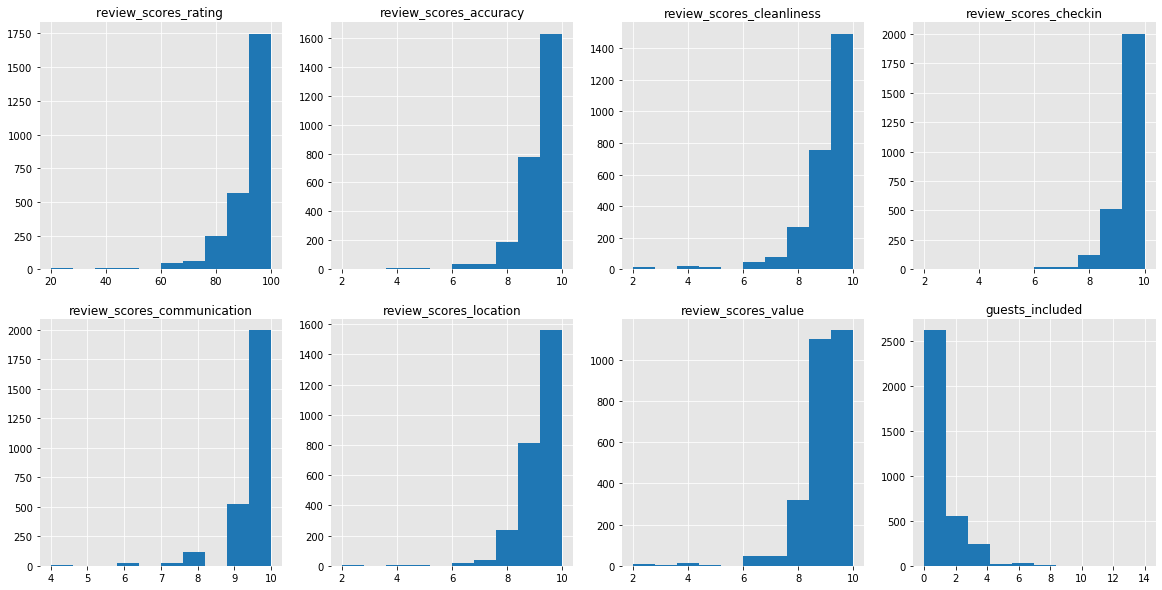

In [37]:
plt.rcParams['figure.figsize'] = (20,10)

plt.subplot(2,4,1)
a = plt.hist(listing_b_num['review_scores_rating'])
plt.title("review_scores_rating ")
plt.subplot(2,4,2)
a = plt.hist(listing_b_num['review_scores_accuracy'])
plt.title("review_scores_accuracy")
plt.subplot(2,4,3)
a = plt.hist(listing_b_num['review_scores_cleanliness'])
plt.title("review_scores_cleanliness")
plt.subplot(2,4,4)
a = plt.hist(listing_b_num['review_scores_checkin'])
plt.title("review_scores_checkin")

plt.subplot(2,4,5)
a = plt.hist(listing_b_num['review_scores_communication'])
plt.title("review_scores_communication")
plt.subplot(2,4,6)
a = plt.hist(listing_b_num['review_scores_location'])
plt.title("review_scores_location")
plt.subplot(2,4,7)
a = plt.hist(listing_b_num['review_scores_value'])
plt.title("review_scores_value")
plt.subplot(2,4,8)
a = plt.hist(listing_b_num['guests_included'])
plt.title("guests_included")

From the histgrams of numerical varialbes, we can see values are not normally distributed. So we will fill the rest of missing values with median, instead of mean.

In [76]:
# fill nan with mean
listing_b_num=listing_b_num.apply(lambda x: x.fillna(x.median()))

                                  
# drop columns with all same values in it
listing_b=listing_b.drop(columns=[i for i in listing_b.columns if len(listing_b[i].value_counts())==1])

print('percentage missing values after dropping and filling nan values\n')
print(listing_b_num.isnull().sum()/len(listing_b)*100)

percentage missing values after dropping and filling nan values

scrape_id                         0.0
host_response_rate                0.0
host_acceptance_rate              0.0
host_total_listings_count         0.0
latitude                          0.0
longitude                         0.0
accommodates                      0.0
bathrooms                         0.0
bedrooms                          0.0
beds                              0.0
price                             0.0
cleaning_fee                      0.0
guests_included                   0.0
extra_people                      0.0
minimum_nights                    0.0
maximum_nights                    0.0
availability_30                   0.0
availability_60                   0.0
availability_90                   0.0
availability_365                  0.0
number_of_reviews                 0.0
review_scores_rating              0.0
review_scores_accuracy            0.0
review_scores_cleanliness         0.0
review_scores_checkin  

In [77]:
listing_b_num.shape

(3461, 29)

Now let's look at missing values in categorical variables

bed_type                  0.00000
room_type                 0.00000
property_type             0.08668
is_location_exact         0.00000
neighbourhood_cleansed    0.00000
host_is_superhost         0.00000
dtype: float64


Text(0.5, 1.0, 'property_type ')

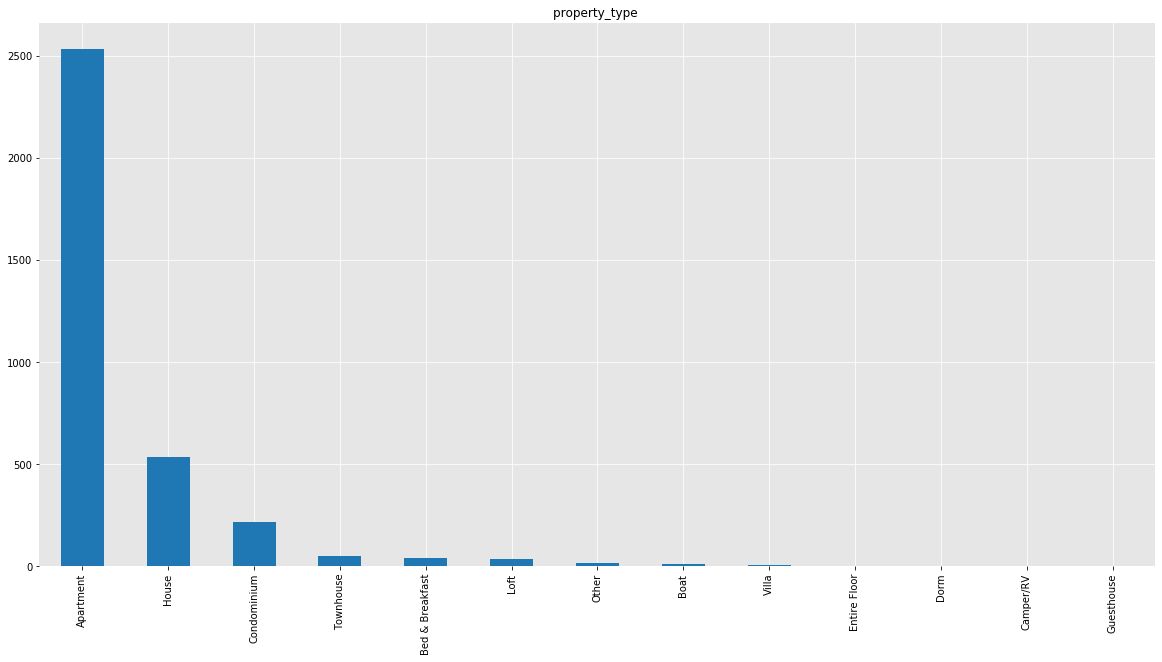

In [65]:
# get categorical variables and create dummies
cat_lst=['bed_type','room_type','property_type','is_location_exact','neighbourhood_cleansed','host_is_superhost']
listing_b_cat=listing_b[cat_lst]
print(listing_b_cat.isnull().sum()/len(listing_b)*100)

# plot property type histgram
listing_b_cat['property_type'].value_counts().plot(kind='bar')
plt.title("property_type ")

Only property_type has missing values and missing values are less than 0.1%. we will fill missing value with mode.

In [66]:
listing_b_cat['property_type']=listing_b_cat['property_type'].fillna('Apartment')
listing_b_cat=pd.get_dummies(listing_b[cat_lst],drop_first=True)

import machine learnig model libraries

In [25]:
from sklearn.ensemble import RandomForestRegressor as forest
from sklearn.linear_model import LinearRegression as linear
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import Ridge, RidgeCV

In [67]:
#combine numerical and categorical datasets
df=pd.concat([listing_b_num,listing_b_cat],axis=1)

#create model 
X=df.drop(columns=['price'])
y=df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

models=[forest(n_estimators=150),linear(normalize=True),Ridge(alpha =0.05, normalize=True)]
names=['RandomeForest','LinearRegression','Ridge']

# test three models' performance and evaluate
for i in range(len(models)):
    model1=models[i]
    model1=model1.fit(X_train,y_train)
    pred=model1.predict(X_test)
    
    # model evaluation
    mae_train=mean_absolute_error(y_train,model1.predict(X_train))
    r2_train=r2_score(y_train,model1.predict(X_train))
    mae_test= mean_absolute_error(y_test, pred)
    r2_test=r2_score(y_test, pred)

    print( names[i],' MAE_test ',mae_test)
    print(names[i],' R2_test ',r2_test)

    print(names[i],' MAE_train ',mae_train)
    print(names[i],' R2_train ',r2_train)

RandomeForest  MAE_test  32.63179980750722
RandomeForest  R2_test  0.7354911002195573
RandomeForest  MAE_train  11.999856867602533
RandomeForest  R2_train  0.9595769203089555
LinearRegression  MAE_test  3232596687193.719
LinearRegression  R2_test  -1.3524366126247355e+24
LinearRegression  MAE_train  36.319171409027994
LinearRegression  R2_train  0.6611549000530981
Ridge  MAE_test  694.9437287195323
Ridge  R2_test  -55847.11267701491
Ridge  MAE_train  36.4294668811329
Ridge  R2_train  0.6597598807097729


Out of all three models, random forest performs the best with a 0.73 R2 score and 32 MAE on a test set. 

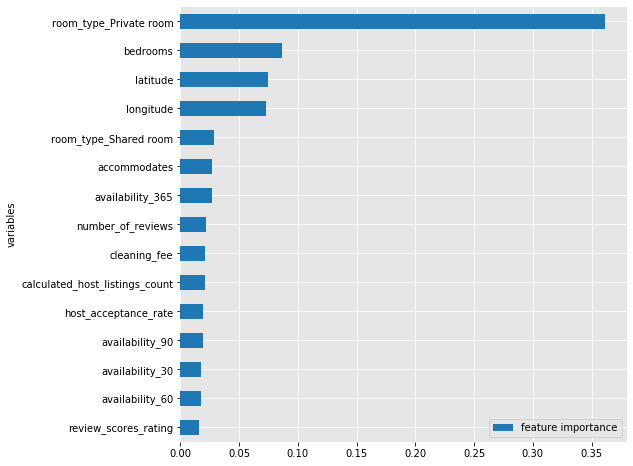

In [78]:
#get RandomForest feature importance rank
model=forest(n_estimators=150).fit(X_train,y_train)
pred=model.predict(X_test)
importance=pd.DataFrame({'variables':X_train.columns,'feature importance':model.feature_importances_}).\
                                                    sort_values(by=['feature importance'],ascending=False)
importance.iloc[:15,:].sort_values(by=['feature importance']).plot(kind='barh',y='feature importance',x='variables',figsize=[8,8])


From the model importance ranking, we can see number of bedrooms, room types and location are the most important price predictors.